In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from scikitplot.metrics import plot_roc
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay






In [7]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [8]:
TRAIN_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
VAL_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/'
TEST_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'

In [9]:
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpeg")
val_images = glob.glob(f"{VAL_PATH}**/*.jpeg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpeg")

In [ ]:
# train_size = len(train_images)
# val_size = len(val_images)
# test_size = len(test_images)


# # View the counts
# train_size
# val_size
# test_size


In [10]:
def generate_labels(image_paths):
    labels = []
    for _ in image_paths:
        if ('PNEUMONIA' in _.replace('chest-xray-pneumonia', '')):
            labels.append('PNEUMONIA')
        else:
            labels.append('NORMAL')
            
    return labels

def build_df(image_paths, labels):
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'NORMAL' else 1, axis=1)
    
    return df.sample(frac=1, random_state=CFG.SEED).reset_index()

In [11]:
train_df = build_df(train_images, generate_labels(train_images))
val_df = build_df(val_images, generate_labels(val_images))
test_df = build_df(test_images, generate_labels(test_images))

In [12]:
def _load(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    image = tf.cast(image, tf.float32)/255.
    return image

def view_sample(image, label):
    plt.figure(figsize=(8, 10))
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}', fontsize=16)
    return

2023-01-18 15:45:56.273381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 15:45:56.445597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 15:45:56.446704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 15:45:56.449730: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

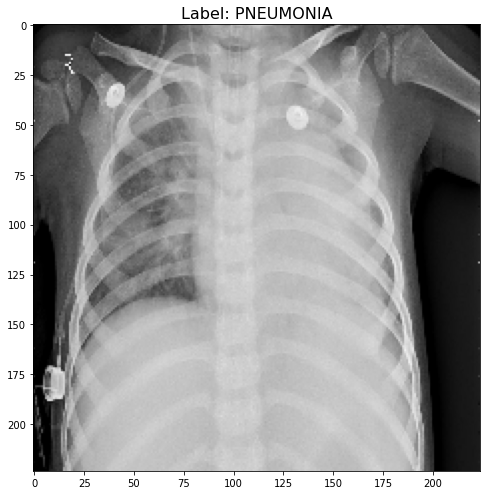

In [13]:
idx = random.sample(train_df.index.to_list(), 1)[0]

sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

view_sample(sample_image, sample_label)

In [ ]:
# plt.figure(figsize=(15, 8))
# plt.title('Train Labels Distribution')
# train_df['label'].value_counts().plot(kind='barh');

In [ ]:
# plt.figure(figsize=(15, 8))
# plt.title('Validation Labels Distribution')
# val_df['label'].value_counts().plot(kind='barh');

In [ ]:
# plt.figure(figsize=(15, 8))
# plt.title('Test Labels Distribution')
# test_df['label'].value_counts().plot(kind='barh');

In [14]:
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index, 
                                                        train_df.label_encoded, 
                                                        test_size=0.2,
                                                        stratify=train_df.label,
                                                        random_state=CFG.SEED)

In [15]:
train_split_df = train_df.iloc[train_split_idx]
val_split_df = pd.concat([val_df, train_df.iloc[val_split_idx]], axis=0)

In [ ]:
# plt.figure(figsize=(15, 8))
# plt.title('New Train Labels Distribution')
# train_split_df['label'].value_counts().plot(kind='barh');

In [ ]:
# plt.figure(figsize=(15, 8))
# plt.title('New Validation Labels Distribution')
# val_split_df['label'].value_counts().plot(kind='barh');

In [16]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.2), width_factor=(-0.1, 0.2)),
], name='augmentation_layer')

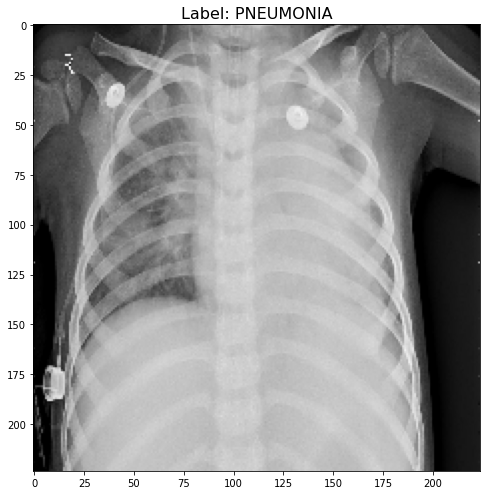

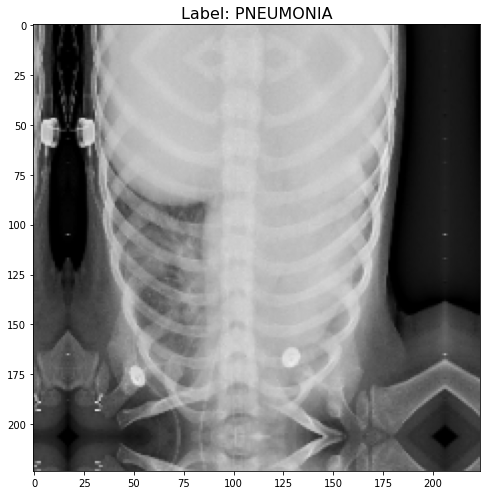

In [17]:
# View augmented sample
view_sample(sample_image, sample_label)
view_sample(augmentation_layer(sample_image), sample_label)

In [18]:
def encode_labels(labels):
    return tf.one_hot(labels, depth=2).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=False, prefetch=False):
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE
    

    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    

    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    
    ds = ds.batch(batch_size)
 
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)
    
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [19]:

train_ds = create_pipeline(train_split_df, _load, augment=True, batch_size=32, shuffle=False, prefetch=False)
val_ds = create_pipeline(val_split_df, _load, batch_size=32, shuffle=False, prefetch=False)
test_ds = create_pipeline(test_df, _load, batch_size=32, shuffle=False, prefetch=False)

In [20]:

train_labels_one_hot = encode_labels(train_df.label_encoded)
val_labels_one_hot = encode_labels(val_df.label_encoded)
test_labels_one_hot = encode_labels(test_df.label_encoded)

In [29]:
def cnn_model():
    
    initializer = tf.keras.initializers.GlorotNormal()
    
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        
        layers.Conv2D(32, kernel_size=3, activation='relu',kernel_initializer=initializer),
        layers.Conv2D(32, kernel_size=3, activation='relu',kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2,padding='valid'),
        
        layers.Conv2D(64, kernel_size=3, activation='relu',kernel_initializer=initializer),
        layers.Conv2D(64, kernel_size=3, activation='relu',kernel_initializer=initializer ),
        layers.MaxPool2D(pool_size=2,padding='valid'),
        layers.Dropout(0.4), 
        
        layers.Conv2D(128, kernel_size=3, activation='relu',kernel_initializer=initializer),
        layers.Conv2D(128, kernel_size=3, activation='relu',kernel_initializer=initializer ),
        layers.MaxPool2D(pool_size=2),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(2, activation='sigmoid',kernel_initializer=initializer),
    ], name='cnn_sequential_model')
    
    return cnn_sequential

In [30]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 53, 53, 64

In [ ]:
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

In [23]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = CFG.EPOCHS
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [32]:
tf.random.set_seed(CFG.SEED)


model_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)



cnn_history = model_cnn.fit(train_ds,
                                  epochs=30,
                                  validation_data=val_ds,callbacks=CALLBACKS)

Epoch 1/30
131/131 [==============================] - 78s 593ms/step - loss: 0.1757 - accuracy: 0.9343 - val_loss: 0.1974 - val_accuracy: 0.9387
Epoch 2/30
131/131 [==============================] - 77s 588ms/step - loss: 0.1541 - accuracy: 0.9382 - val_loss: 0.1604 - val_accuracy: 0.9425
Epoch 3/30
131/131 [==============================] - 79s 604ms/step - loss: 0.1598 - accuracy: 0.9430 - val_loss: 0.1946 - val_accuracy: 0.9255
Epoch 4/30
131/131 [==============================] - 79s 605ms/step - loss: 0.1399 - accuracy: 0.9487 - val_loss: 0.1799 - val_accuracy: 0.9330

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
131/131 [==============================] - 80s 610ms/step - loss: 0.1134 - accuracy: 0.9597 - val_loss: 0.1332 - val_accuracy: 0.9491
Epoch 6/30
131/131 [==============================] - 78s 593ms/step - loss: 0.1132 - accuracy: 0.9597 - val_loss: 0.1343 - val_accuracy: 0.9481
Epoch 7/30
131/131 [============================

In [54]:

cnn_evaluation = model_cnn.evaluate(test_ds)

20/20 [==============================] - 8s 409ms/step - loss: 0.4761 - accuracy: 0.8237


In [34]:
mobilenet_v2 = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                          trainable=False,
                          name='mobilenet_v2')

In [127]:
model_mobilenet_v2 = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        mobilenet_v2,
        layers.Dropout(0.2),
        layers.Dense(2, activation='sigmoid', dtype=tf.float32)
    ], name='resnet_sequential_model')

# model_resnet.summary()

In [128]:
tf.random.set_seed(CFG.SEED)

model_mobilenet_v2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


mobilenet_v2_history = model_mobilenet_v2.fit(train_ds,
                                  epochs=30,
                                  validation_data=val_ds,callbacks=CALLBACKS)

Epoch 1/30
131/131 [==============================] - 74s 555ms/step - loss: 0.3300 - accuracy: 0.8674 - val_loss: 0.2106 - val_accuracy: 0.9340
Epoch 2/30
131/131 [==============================] - 72s 550ms/step - loss: 0.1873 - accuracy: 0.9338 - val_loss: 0.1853 - val_accuracy: 0.9406
Epoch 3/30
131/131 [==============================] - 71s 544ms/step - loss: 0.1565 - accuracy: 0.9425 - val_loss: 0.1649 - val_accuracy: 0.9500
Epoch 4/30
131/131 [==============================] - 72s 549ms/step - loss: 0.1390 - accuracy: 0.9511 - val_loss: 0.1605 - val_accuracy: 0.9481
Epoch 5/30
131/131 [==============================] - 72s 552ms/step - loss: 0.1291 - accuracy: 0.9525 - val_loss: 0.1576 - val_accuracy: 0.9491
Epoch 6/30
131/131 [==============================] - 72s 552ms/step - loss: 0.1268 - accuracy: 0.9523 - val_loss: 0.1533 - val_accuracy: 0.9462
Epoch 7/30
131/131 [==============================] - 72s 552ms/step - loss: 0.1203 - accuracy: 0.9561 - val_loss: 0.1505 - val_ac

In [129]:
mobilenet_v2_evaluation = model_mobilenet_v2.evaluate(test_ds)

20/20 [==============================] - 6s 317ms/step - loss: 0.4401 - accuracy: 0.8205


In [37]:
inception_v3 = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",
                          trainable=False,
                          name='inception_v3')


In [38]:
model_inception_v3 = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        inception_v3,
        layers.Dropout(0.2),
        layers.Dense(2, activation='sigmoid', dtype=tf.float32)
    ], name='resnet_sequential_model')


# model_resnet.summary()

In [39]:
tf.random.set_seed(CFG.SEED)

model_inception_v3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


inception_v3_history = model_inception_v3.fit(train_ds,
                                  epochs=30,
                                  validation_data=val_ds,callbacks=CALLBACKS)

Epoch 1/30
131/131 [==============================] - 79s 564ms/step - loss: 0.3693 - accuracy: 0.8483 - val_loss: 0.2996 - val_accuracy: 0.8547
Epoch 2/30
131/131 [==============================] - 73s 560ms/step - loss: 0.2379 - accuracy: 0.9034 - val_loss: 0.2184 - val_accuracy: 0.9208
Epoch 3/30
131/131 [==============================] - 72s 547ms/step - loss: 0.2180 - accuracy: 0.9163 - val_loss: 0.2255 - val_accuracy: 0.9066
Epoch 4/30
131/131 [==============================] - 72s 549ms/step - loss: 0.1978 - accuracy: 0.9259 - val_loss: 0.1992 - val_accuracy: 0.9236
Epoch 5/30
131/131 [==============================] - 72s 547ms/step - loss: 0.1876 - accuracy: 0.9228 - val_loss: 0.1778 - val_accuracy: 0.9283
Epoch 6/30
131/131 [==============================] - 73s 557ms/step - loss: 0.1882 - accuracy: 0.9262 - val_loss: 0.1766 - val_accuracy: 0.9311
Epoch 7/30
131/131 [==============================] - 73s 559ms/step - loss: 0.1787 - accuracy: 0.9319 - val_loss: 0.1737 - val_ac

In [56]:
inception_v3_evaluation = model_inception_v3.evaluate(test_ds)

20/20 [==============================] - 8s 338ms/step - loss: 0.4481 - accuracy: 0.8109


In [41]:
resnet50_v2 = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
                           trainable=False,
                          name='resnet50_v2')

In [42]:
model_resnet = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        resnet50_v2,
        layers.Dropout(0.2),
        layers.Dense(2, activation='sigmoid', dtype=tf.float32)
    ], name='resnet_sequential_model')


# model_resnet.summary()

In [43]:
tf.random.set_seed(CFG.SEED)

model_resnet.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


resnet_history = model_resnet.fit(train_ds,
                                  epochs=30,
                                  validation_data=val_ds,callbacks=CALLBACKS)

Epoch 1/30
131/131 [==============================] - 79s 574ms/step - loss: 0.3061 - accuracy: 0.8792 - val_loss: 0.1592 - val_accuracy: 0.9358
Epoch 2/30
131/131 [==============================] - 82s 627ms/step - loss: 0.1805 - accuracy: 0.9346 - val_loss: 0.1334 - val_accuracy: 0.9462
Epoch 3/30
131/131 [==============================] - 74s 564ms/step - loss: 0.1536 - accuracy: 0.9406 - val_loss: 0.1251 - val_accuracy: 0.9519
Epoch 4/30
131/131 [==============================] - 74s 563ms/step - loss: 0.1432 - accuracy: 0.9456 - val_loss: 0.1208 - val_accuracy: 0.9519
Epoch 5/30
131/131 [==============================] - 74s 565ms/step - loss: 0.1418 - accuracy: 0.9446 - val_loss: 0.1189 - val_accuracy: 0.9500
Epoch 6/30
131/131 [==============================] - 74s 565ms/step - loss: 0.1344 - accuracy: 0.9494 - val_loss: 0.1165 - val_accuracy: 0.9519
Epoch 7/30
131/131 [==============================] - 74s 564ms/step - loss: 0.1253 - accuracy: 0.9511 - val_loss: 0.1112 - val_ac

In [57]:
resnet_evaluation = model_resnet.evaluate(test_ds)

20/20 [==============================] - 8s 386ms/step - loss: 0.3573 - accuracy: 0.8686


In [47]:
efficientnet_v1_b0 = hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                           trainable=False,
                          name='resnet50_v2')

In [48]:

initializer = tf.keras.initializers.GlorotNormal()
model_efficientnet_v1 = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        efficientnet_v1_b0,
        layers.Dropout(0.2),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='efficientnet_v1_sequential_model')


model_efficientnet_v1.summary()

Model: "efficientnet_v1_sequential_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_v2 (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


In [49]:
tf.random.set_seed(CFG.SEED)


model_efficientnet_v1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

efficientnet_v1_history = model_efficientnet_v1.fit(train_ds,
                                  epochs=30,
                                  validation_data=val_ds,callbacks=CALLBACKS)

Epoch 1/30
131/131 [==============================] - 81s 562ms/step - loss: 0.3555 - accuracy: 0.8392 - val_loss: 0.2460 - val_accuracy: 0.9104
Epoch 2/30
131/131 [==============================] - 73s 561ms/step - loss: 0.2282 - accuracy: 0.9072 - val_loss: 0.2034 - val_accuracy: 0.9283
Epoch 3/30
131/131 [==============================] - 72s 553ms/step - loss: 0.1918 - accuracy: 0.9317 - val_loss: 0.1853 - val_accuracy: 0.9396
Epoch 4/30
131/131 [==============================] - 73s 554ms/step - loss: 0.1769 - accuracy: 0.9312 - val_loss: 0.1779 - val_accuracy: 0.9387
Epoch 5/30
131/131 [==============================] - 72s 553ms/step - loss: 0.1556 - accuracy: 0.9477 - val_loss: 0.1675 - val_accuracy: 0.9443
Epoch 6/30
131/131 [==============================] - 73s 558ms/step - loss: 0.1535 - accuracy: 0.9418 - val_loss: 0.1572 - val_accuracy: 0.9453
Epoch 7/30
131/131 [==============================] - 72s 553ms/step - loss: 0.1418 - accuracy: 0.9463 - val_loss: 0.1578 - val_ac

In [58]:
efficientnet_v1_evaluation = model_efficientnet_v1.evaluate(test_ds)

20/20 [==============================] - 8s 345ms/step - loss: 0.3749 - accuracy: 0.8526


In [50]:
efficientnet_v2_b0 = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
                           trainable=False,
                          name='efficientnet_v2_b0')

In [51]:
model_efficientnet_v2 =  Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')
# model_efficientnet_v2.summary()

In [53]:
tf.random.set_seed(CFG.SEED)


model_efficientnet_v2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)


efficientnet_v2_history = model_efficientnet_v2.fit(train_ds,
                                  epochs=30,
                                  validation_data=val_ds,callbacks=CALLBACKS)

Epoch 1/30
131/131 [==============================] - 79s 565ms/step - loss: 0.3498 - accuracy: 0.8504 - val_loss: 0.2273 - val_accuracy: 0.9142
Epoch 2/30
131/131 [==============================] - 74s 567ms/step - loss: 0.2075 - accuracy: 0.9274 - val_loss: 0.1873 - val_accuracy: 0.9264
Epoch 3/30
131/131 [==============================] - 76s 581ms/step - loss: 0.1786 - accuracy: 0.9331 - val_loss: 0.1685 - val_accuracy: 0.9349
Epoch 4/30
131/131 [==============================] - 74s 566ms/step - loss: 0.1596 - accuracy: 0.9396 - val_loss: 0.1625 - val_accuracy: 0.9358
Epoch 5/30
131/131 [==============================] - 71s 545ms/step - loss: 0.1407 - accuracy: 0.9494 - val_loss: 0.1511 - val_accuracy: 0.9387
Epoch 6/30
131/131 [==============================] - 73s 555ms/step - loss: 0.1365 - accuracy: 0.9489 - val_loss: 0.1626 - val_accuracy: 0.9349
Epoch 7/30
131/131 [==============================] - 72s 553ms/step - loss: 0.1282 - accuracy: 0.9545 - val_loss: 0.1490 - val_ac

In [59]:

efficientnet_v2_evaluation = model_efficientnet_v2.evaluate(test_ds)

20/20 [==============================] - 7s 366ms/step - loss: 0.3318 - accuracy: 0.8766


In [61]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))


    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.set_title('Loss (Lower is Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

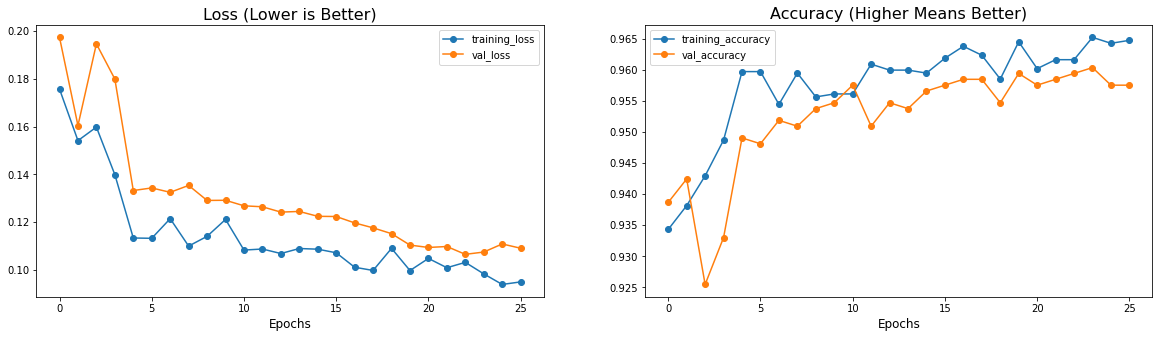

In [63]:
# plot cnn model training history 
plot_training_curves(cnn_history)

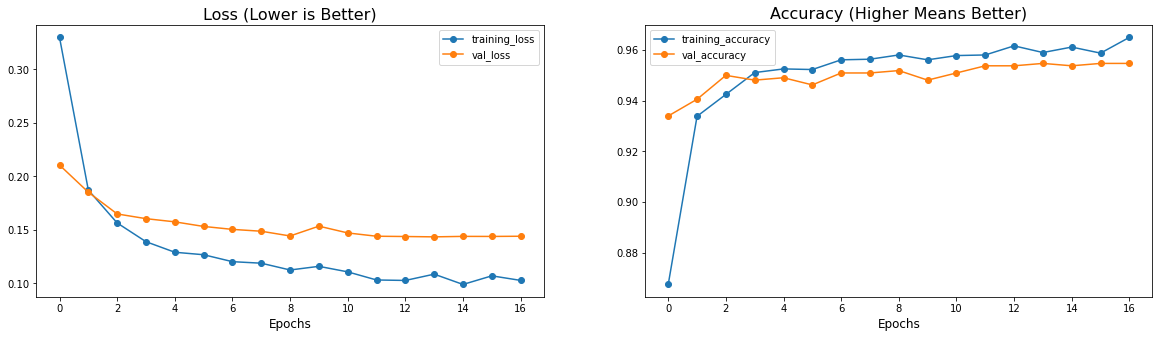

In [130]:
plot_training_curves(mobilenet_v2_history)

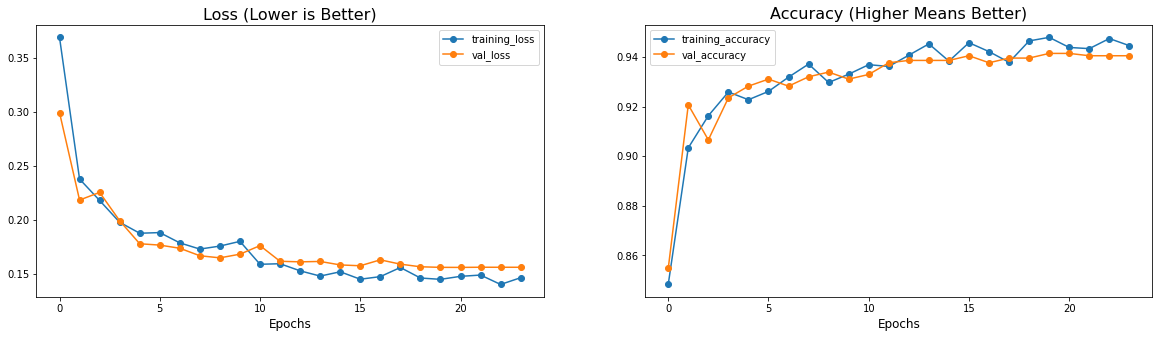

In [67]:
plot_training_curves(inception_v3_history)

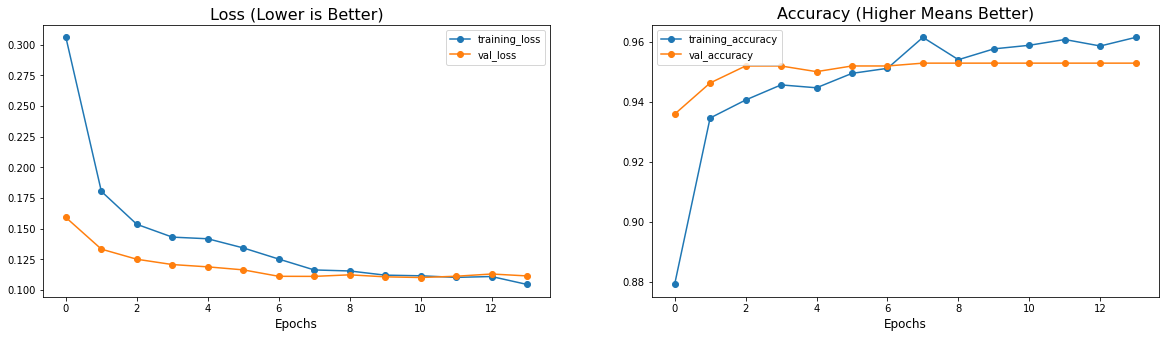

In [73]:
# Plot ResNet50 V2 model training history 
plot_training_curves(resnet_history)

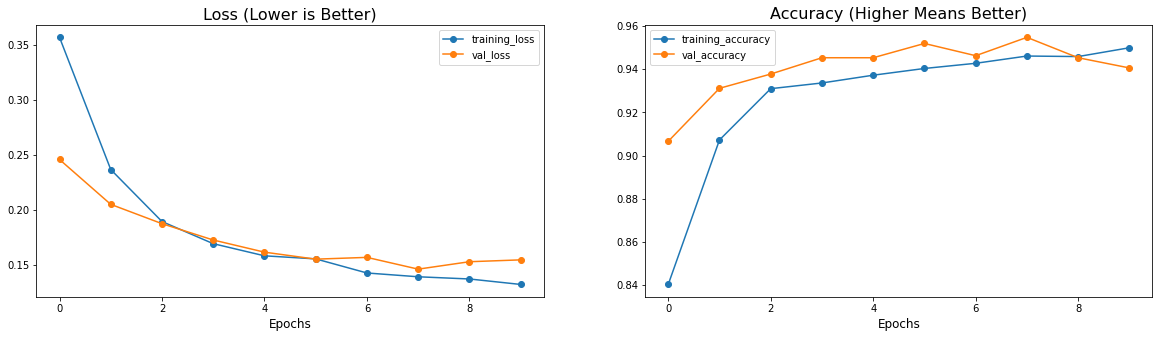

In [74]:
# Plot EfficientNet V1 B0 model training history
plot_training_curves(efficientnet_v1_history)

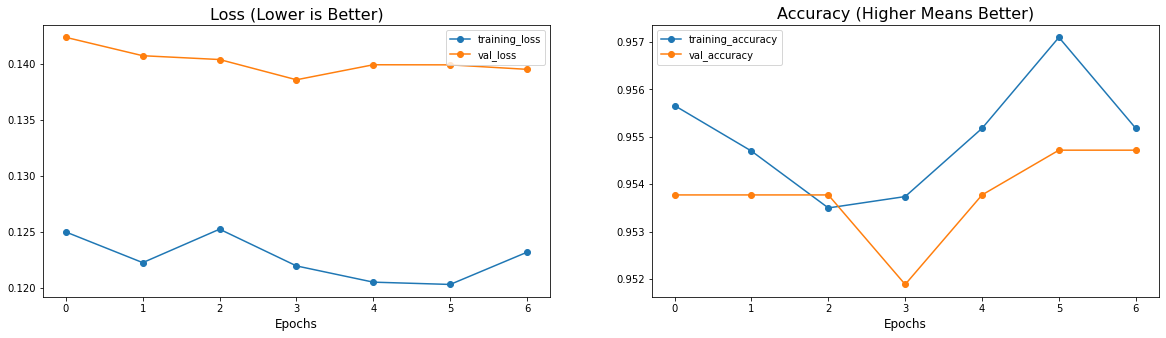

In [75]:
# Plot EfficientNet V2 B0 model training history 
plot_training_curves(efficientnet_v2_history)

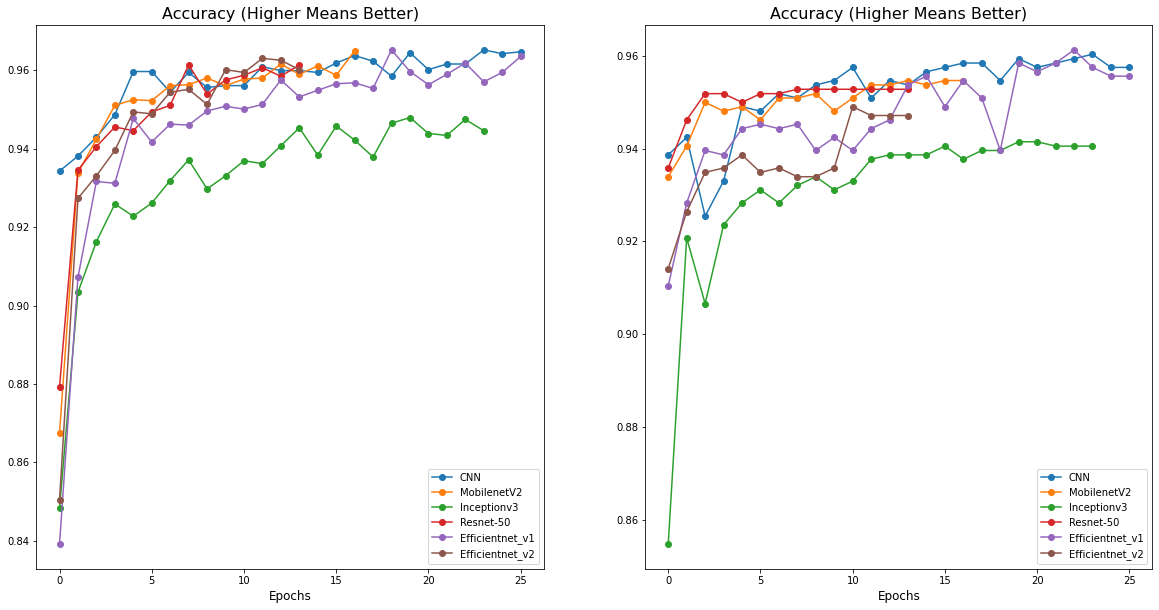

In [131]:
cnn_loss = np.array(cnn_history.history['loss'])
cnn_val_loss = np.array(cnn_history.history['val_loss'])
cnn_accuracy = np.array(cnn_history.history['accuracy'])
cnn_val_accuracy = np.array(cnn_history.history['val_accuracy'])

mv2_loss = np.array(mobilenet_v2_history.history['loss'])
mv2_val_loss = np.array(mobilenet_v2_history.history['val_loss'])
mv2_accuracy = np.array(mobilenet_v2_history.history['accuracy'])
mv2_val_accuracy = np.array(mobilenet_v2_history.history['val_accuracy'])

inceptionv3_loss = np.array(inception_v3_history.history['loss'])
inceptionv3_val_loss = np.array(inception_v3_history.history['val_loss'])
inceptionv3_accuracy = np.array(inception_v3_history.history['accuracy'])
inceptionv3_val_accuracy = np.array(inception_v3_history.history['val_accuracy'])

resnet_loss = np.array(resnet_history.history['loss'])
resnet_val_loss = np.array(resnet_history.history['val_loss'])
resnet_accuracy = np.array(resnet_history.history['accuracy'])
resnet_val_accuracy = np.array(resnet_history.history['val_accuracy'])

efficientnet_v1_loss = np.array(efficientnet_v1_history.history['loss'])
efficientnet_v1_val_loss = np.array(efficientnet_v1_history.history['val_loss'])
efficientnet_v1_accuracy = np.array(efficientnet_v1_history.history['accuracy'])
efficientnet_v1_val_accuracy = np.array(efficientnet_v1_history.history['val_accuracy'])

efficientnet_v2_loss = np.array(efficientnet_v2_history.history['loss'])
efficientnet_v2_val_loss = np.array(efficientnet_v2_history.history['val_loss'])
efficientnet_v2_accuracy = np.array(efficientnet_v2_history.history['accuracy'])
efficientnet_v2_val_accuracy = np.array(efficientnet_v2_history.history['val_accuracy'])

epochs = range(0,30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


ax1.plot(range(len(cnn_history.history['accuracy'])), cnn_accuracy, label='CNN', marker='o')
ax1.plot(range(len(mobilenet_v2_history.history['accuracy'])), mv2_accuracy, label='MobilenetV2', marker='o')
ax1.plot(range(len(inception_v3_history.history['accuracy'])), inceptionv3_accuracy, label='Inceptionv3', marker='o')
ax1.plot(range(len(resnet_history.history['accuracy'])), resnet_accuracy, label='Resnet-50', marker='o')
ax1.plot(range(len(efficientnet_v1_history.history['accuracy'])), efficientnet_v1_accuracy, label='Efficientnet_v1', marker='o')
ax1.plot(range(len(efficientnet_v2_history.history['accuracy'])), efficientnet_v2_accuracy, label='Efficientnet_v2', marker='o')
ax1.set_title('Accuracy (Higher Means Better)', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.legend()
ax2.plot(range(len(cnn_history.history['val_accuracy'])), cnn_val_accuracy, label='CNN', marker='o')
ax2.plot(range(len(mobilenet_v2_history.history['val_accuracy'])), mv2_val_accuracy, label='MobilenetV2', marker='o')
ax2.plot(range(len(inception_v3_history.history['val_accuracy'])), inceptionv3_val_accuracy, label='Inceptionv3', marker='o')
ax2.plot(range(len(resnet_history.history['val_accuracy'])), resnet_val_accuracy, label='Resnet-50', marker='o')
ax2.plot(range(len(efficientnet_v1_history.history['val_accuracy'])), efficientnet_v1_val_accuracy, label='Efficientnet_v1', marker='o')
ax2.plot(range(len(efficientnet_v2_history.history['val_accuracy'])), efficientnet_v2_val_accuracy, label='Efficientnet_v2', marker='o')
ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.legend();

20/20 [==============================] - 7s 364ms/step


<Figure size 720x720 with 0 Axes>

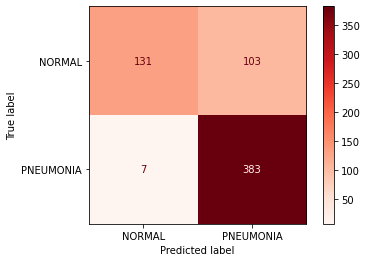

In [133]:
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)
cm = confusion_matrix(test_df.label_encoded, cnn_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

plt.figure(figsize=(10, 10));
disp.plot(cmap=plt.cm.Reds);

20/20 [==============================] - 7s 326ms/step


<Figure size 720x720 with 0 Axes>

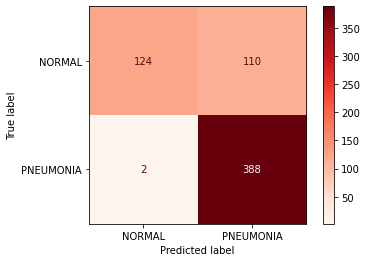

In [132]:
mv2_test_probabilities = model_mobilenet_v2.predict(test_ds, verbose=1)
mv2_test_predictions = tf.argmax(mv2_test_probabilities, axis=1)
cm = confusion_matrix(test_df.label_encoded, mv2_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

plt.figure(figsize=(10, 10));
disp.plot(cmap=plt.cm.Reds);

20/20 [==============================] - 7s 356ms/step


<Figure size 720x720 with 0 Axes>

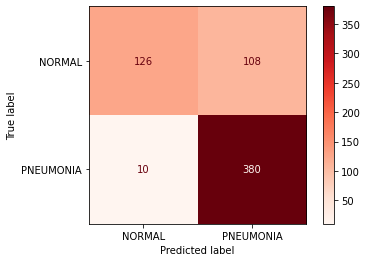

In [124]:
inceptionv3_test_probabilities = model_inception_v3.predict(test_ds, verbose=1)
inceptionv3_test_predictions = tf.argmax(inceptionv3_test_probabilities, axis=1)
cm = confusion_matrix(test_df.label_encoded, inceptionv3_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

plt.figure(figsize=(10, 10));
disp.plot(cmap=plt.cm.Reds);

20/20 [==============================] - 6s 311ms/step


<Figure size 720x720 with 0 Axes>

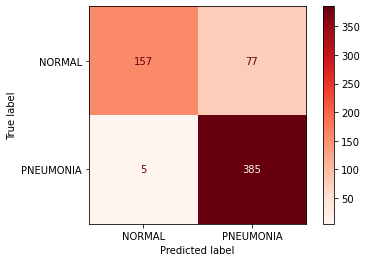

In [123]:
resnet_test_probabilities = model_resnet.predict(test_ds, verbose=1)
resnet_test_predictions = tf.argmax(resnet_test_probabilities, axis=1)
cm = confusion_matrix(test_df.label_encoded, resnet_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

plt.figure(figsize=(10, 10));
disp.plot(cmap=plt.cm.Reds);

20/20 [==============================] - 7s 332ms/step


<Figure size 1008x1008 with 0 Axes>

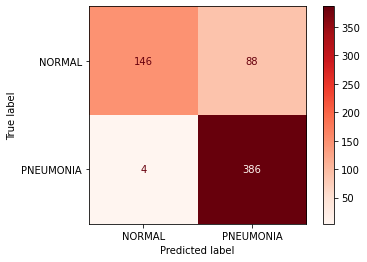

In [122]:
efficientnet_v1_test_probabilities = model_efficientnet_v1.predict(test_ds, verbose=1)
efficientnet_v1_test_predictions = tf.argmax(efficientnet_v1_test_probabilities, axis=1)
cm = confusion_matrix(test_df.label_encoded, efficientnet_v1_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

plt.figure(figsize=(14, 14));
disp.plot(cmap=plt.cm.Reds);

20/20 [==============================] - 7s 333ms/step


<Figure size 1008x1008 with 0 Axes>

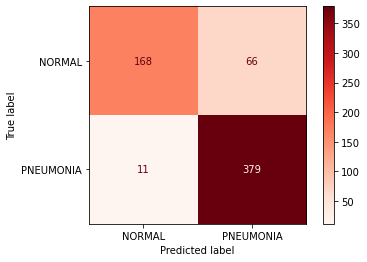

In [121]:
efficientnet_v2_test_probabilities = model_efficientnet_v2.predict(test_ds, verbose=1)
efficientnet_v2_test_predictions = tf.argmax(efficientnet_v2_test_probabilities, axis=1)
cm = confusion_matrix(test_df.label_encoded, efficientnet_v2_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

plt.figure(figsize=(14, 14));
disp.plot(cmap=plt.cm.Reds);

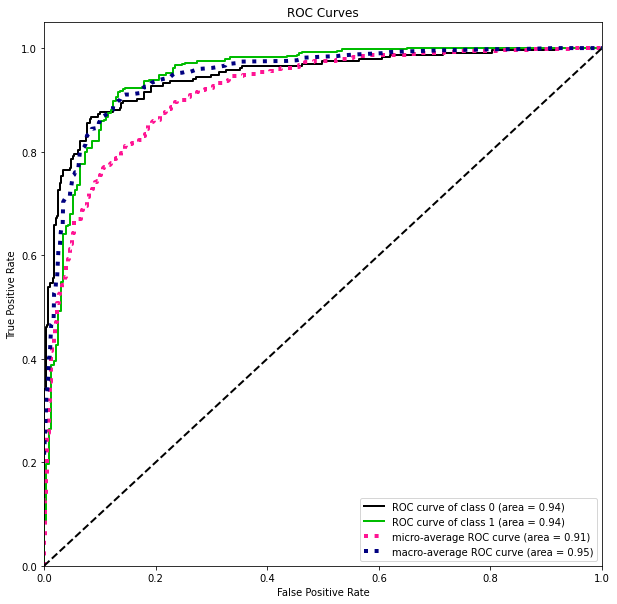

In [88]:
plot_roc(test_df.label_encoded, cnn_test_probabilities, figsize=(10, 10), title_fontsize='large');

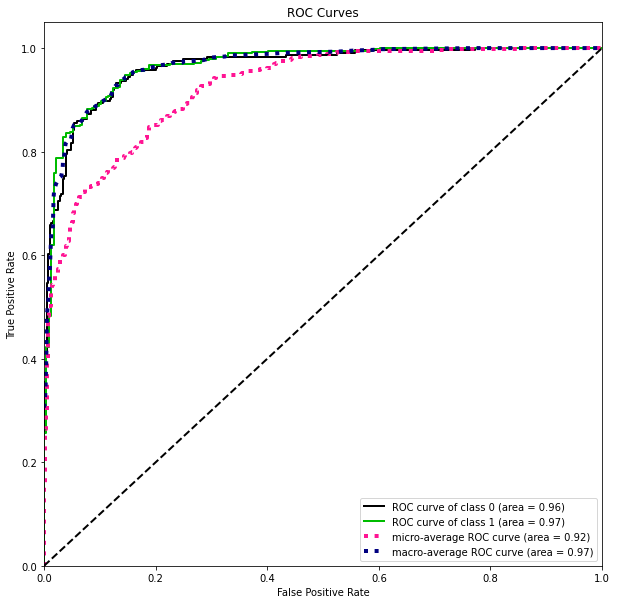

In [134]:
plot_roc(test_df.label_encoded, mv2_test_probabilities, figsize=(10, 10), title_fontsize='large');

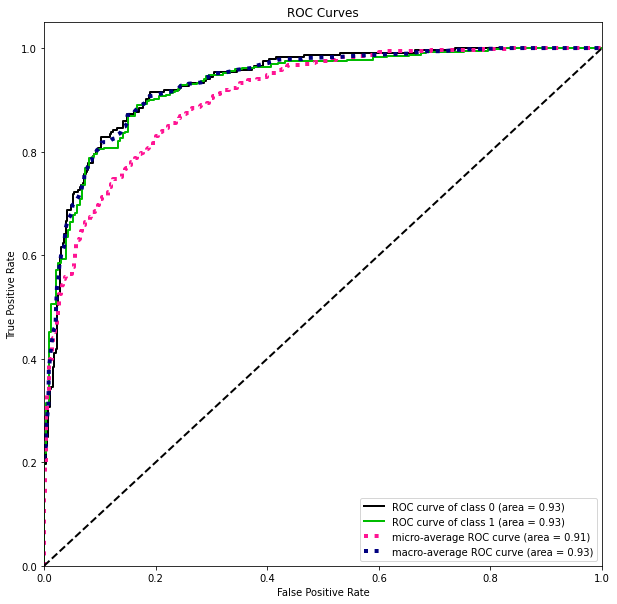

In [90]:
plot_roc(test_df.label_encoded, inceptionv3_test_probabilities, figsize=(10, 10), title_fontsize='large');

<Figure size 720x576 with 0 Axes>

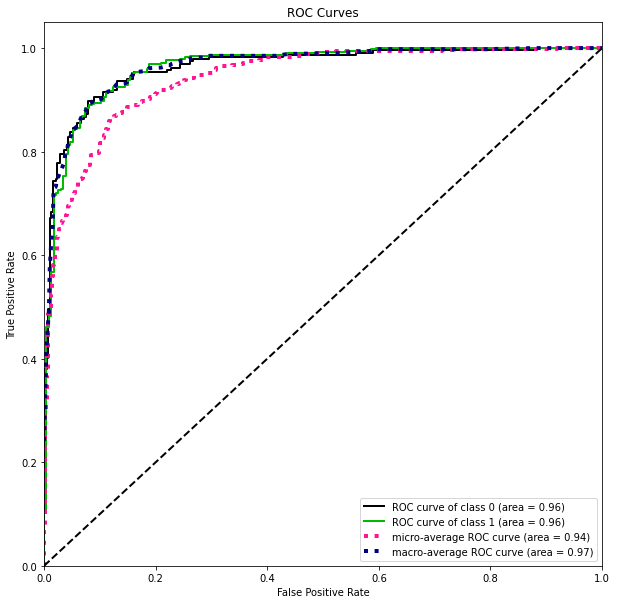

In [91]:
plt.figure(figsize=(10, 8))
plot_roc(test_df.label_encoded, resnet_test_probabilities, figsize=(10, 10), title_fontsize='large');

<Figure size 720x576 with 0 Axes>

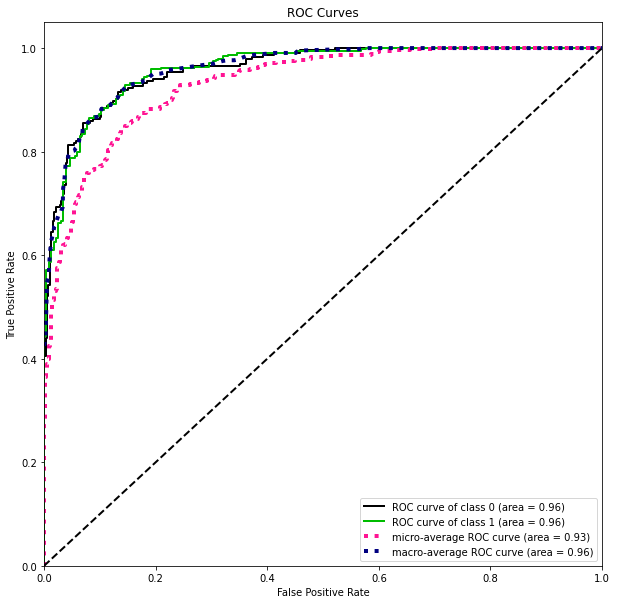

In [92]:
plt.figure(figsize=(10, 8))
plot_roc(test_df.label_encoded, efficientnet_v1_test_probabilities, figsize=(10, 10), title_fontsize='large');

<Figure size 720x576 with 0 Axes>

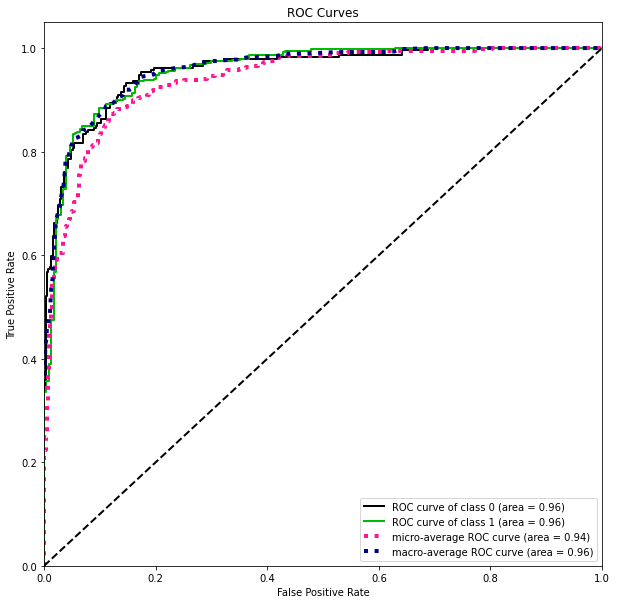

In [93]:
plt.figure(figsize=(10, 8))
plot_roc(test_df.label_encoded, efficientnet_v2_test_probabilities, figsize=(10, 10), title_fontsize='large');

In [94]:
print(classification_report(test_df.label_encoded, cnn_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.56      0.70       234
   PNEUMONIA       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



In [135]:
print(classification_report(test_df.label_encoded, mv2_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.53      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.86      0.82      0.80       624



In [96]:
print(classification_report(test_df.label_encoded, inceptionv3_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.93      0.54      0.68       234
   PNEUMONIA       0.78      0.97      0.87       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.77       624
weighted avg       0.83      0.81      0.80       624



In [97]:
print(classification_report(test_df.label_encoded, resnet_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.67      0.79       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



In [98]:
print(classification_report(test_df.label_encoded, efficientnet_v1_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.62      0.76       234
   PNEUMONIA       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624



In [99]:
print(classification_report(test_df.label_encoded, efficientnet_v2_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.72      0.81       234
   PNEUMONIA       0.85      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.88      0.88      0.87       624



In [139]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    

    print(f'\nPerformance Metrics:\n')
  
    print(f'accuracy_score:\t\t{model_accuracy}\n')
 
    print(f'precision_score:\t{model_precision}\n')

    print(f'recall_score:\t\t{model_recall}\n')

    print(f'f1_score:\t\t{model_f1}\n')

    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
   
    
    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores

In [103]:
cnn_performance = generate_preformance_scores(test_df.label_encoded, 
                                              cnn_test_predictions, 
                                              cnn_test_probabilities)


Performance Metrics:

accuracy_score:		0.82372

precision_score:	0.8485194131329397

recall_score:		0.8237179487179487

f1_score:		0.8106311680659891

matthews_corrcoef:	0.6321



In [140]:
mv2_performance = generate_preformance_scores(test_df.label_encoded, 
                                              mv2_test_predictions, 
                                              mv2_test_probabilities)


Performance Metrics:

accuracy_score:		0.82051

precision_score:	0.8559954102122777

recall_score:		0.8205128205128205

f1_score:		0.8045045045045046

matthews_corrcoef:	0.63288



In [119]:
# inceptionv3_performance = generate_preformance_scores(test_df.label_encoded, 
#                                               inceptionv3_test_probabilities, 
#                                               inceptionv3_test_predictions)

In [108]:
resnet_performance = generate_preformance_scores(test_df.label_encoded, 
                                                 resnet_test_predictions, 
                                                 resnet_test_probabilities)


Performance Metrics:

accuracy_score:		0.86859

precision_score:	0.8842592592592593

recall_score:		0.8685897435897436

f1_score:		0.8621959026888604

matthews_corrcoef:	0.72672



In [109]:
efficientnet_v1_performance = generate_preformance_scores(test_df.label_encoded,
                                                          efficientnet_v1_test_predictions, 
                                                          efficientnet_v1_test_probabilities)


Performance Metrics:

accuracy_score:		0.85256

precision_score:	0.8739662447257385

recall_score:		0.8525641025641025

f1_score:		0.8436053240740742

matthews_corrcoef:	0.69525



In [110]:
efficientnet_v2_performance = generate_preformance_scores(test_df.label_encoded,
                                                          efficientnet_v2_test_predictions, 
                                                          efficientnet_v2_test_probabilities)


Performance Metrics:

accuracy_score:		0.8766

precision_score:	0.8842586780490868

recall_score:		0.8766025641025641

f1_score:		0.8724500152237896

matthews_corrcoef:	0.73828



In [141]:
performace_df = pd.DataFrame({
    'model_cnn': cnn_performance,
    'model_mv2' : mv2_performance,
    'model_resnet': resnet_performance,
    'model_efficientnet_v1': efficientnet_v1_performance,
    'model_efficientnet_v2': efficientnet_v2_performance,
}).T
performace_df

,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
model_cnn,0.81410,0.851920,0.814103,0.796531,0.61974
model_mv2,0.82051,0.855995,0.820513,0.804505,0.63288
model_resnet,0.86859,0.884259,0.868590,0.862196,0.72672
model_efficientnet_v1,0.85256,0.873966,0.852564,0.843605,0.69525
model_efficientnet_v2,0.87660,0.884259,0.876603,0.872450,0.73828
